In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [66]:
# Data Stuff

num_train = 50000
num_val = 10000
num_test = 10000
batch_size = 512
transform = transforms.Compose([
        transforms.ToTensor(),
    ])
data_path = 'fashion_mnist'
all_training_data = datasets.FashionMNIST(root=data_path, train=True, download=True, transform=transform)
all_testing_data = datasets.FashionMNIST(root=data_path, train=False, download=True, transform=transform)
train_dataset, val_dataset = random_split(all_training_data, [num_train, num_val])
test_dataset = all_testing_data

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [67]:
data = next(iter(train_loader))
print(data[0].min(), data[0].max(), data[0].shape) # Already normalized from 0-1

tensor(0.) tensor(1.) torch.Size([512, 1, 28, 28])


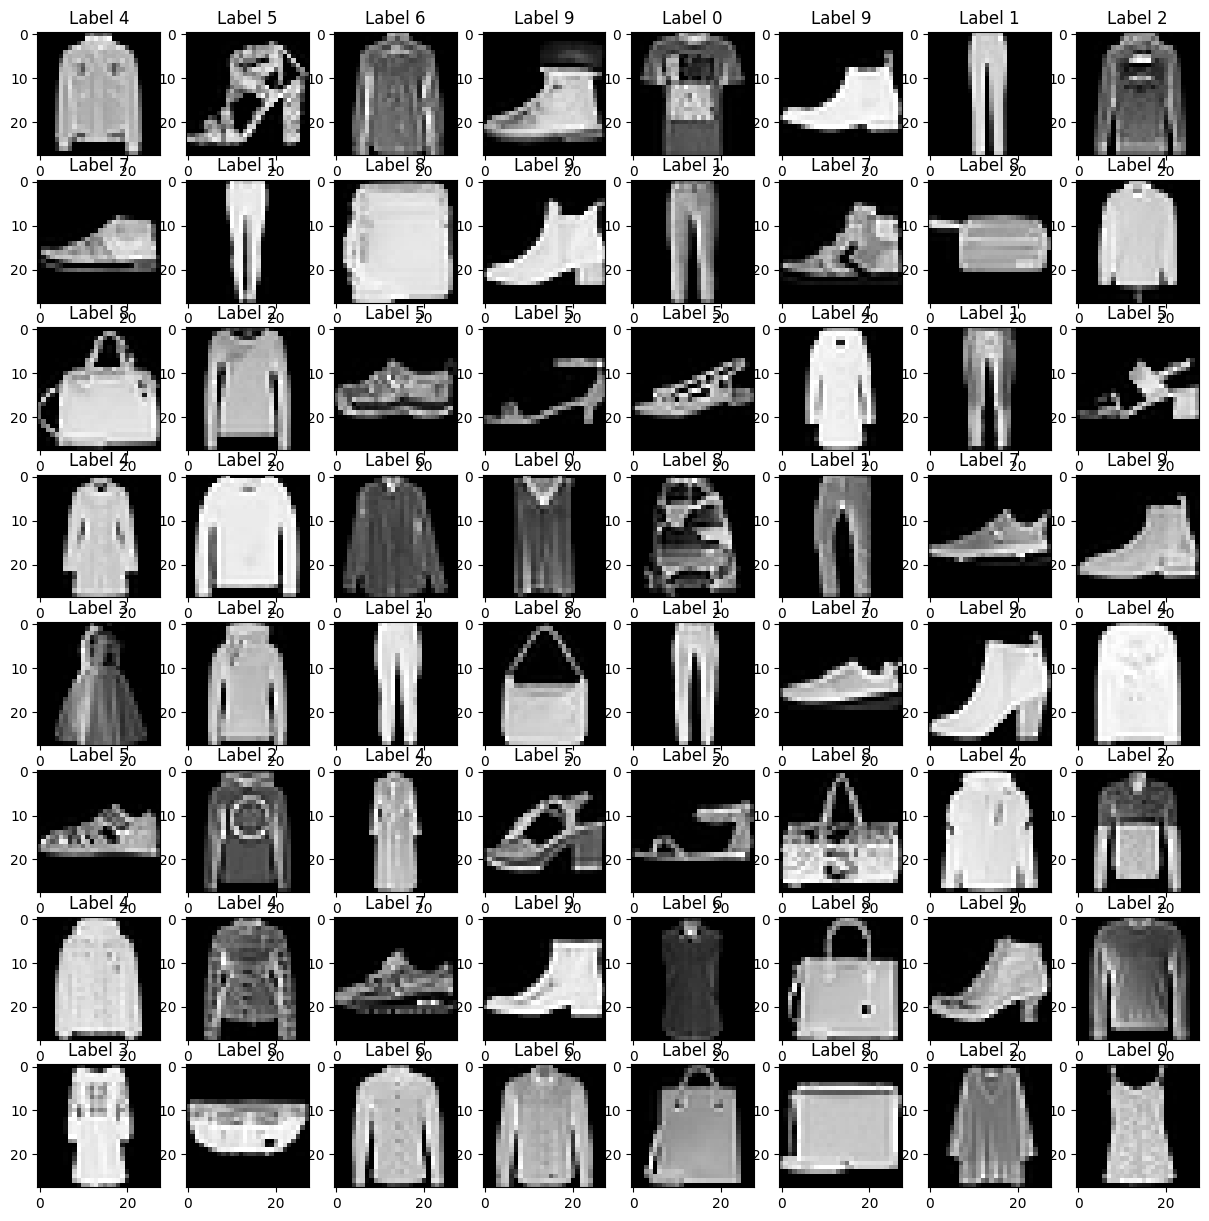

In [68]:
figure = plt.figure(figsize=(15, 15))
ax = figure.subplots(8, 8).flatten()
for i in range(64):
    ax[i].imshow(data[0][i][0], cmap='gray')
    ax[i].set_title(f"Label {data[1][i]}")
plt.show()

In [71]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_convs, num_depths):
        super(LeNet, self).__init__()
        layers = []
        #CNNs1
        layers.extend([nn.Conv2d(1, 6*num_depths, (5, 5), padding=2, bias=True), nn.ReLU()])
        for _ in range(num_convs - 1):
            layers.extend([nn.Conv2d(6*num_depths, 6*num_depths, (5, 5), padding=2, bias=True), nn.ReLU()])
            
        layers.append(nn.MaxPool2d((2, 2), stride=(2, 2)))
        layers.extend([nn.Conv2d(6*num_depths, 16*num_depths, (5, 5), padding=0, bias=True), nn.ReLU()])
        for _ in range(num_convs - 1):
            layers.extend([nn.Conv2d(16*num_depths, 16*num_depths, (5, 5), padding=2, bias=True), nn.ReLU()])
        layers.append(nn.MaxPool2d((2, 2), stride=(2, 2)))
        layers.append(nn.Conv2d(16*num_depths, 120, (5, 5), padding=0, bias=True))
        self.cnn = nn.Sequential(*layers)
        self.FC1 = nn.Linear(120, 84)
        self.FC2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.cnn(x)
        x = self.FC1(x[:,:,0,0])        
        x = F.relu(x)
        x = self.FC2(x) # note we keep the raw logits instead of the softmax
        return x
        
from sklearn.metrics import accuracy_score, confusion_matrix


def iterate_through_dataset(model, loader, optim=None):
    t = time.time()
    losses = []
    preds = []
    gts = []
    data_iter = iter(loader)
    for X, y in loader:
        if optim is None:
            with torch.no_grad():
                logits = model(X.cuda())
        else:
            logits = model(X.cuda())
        preds.append(F.softmax(logits, dim=-1))
        gts.append(y)
        loss = F.cross_entropy(logits, y.cuda(), reduction='none')
        losses.append(loss.detach())
        if optim is not None:
            loss.mean().backward()
            optim.step()
            optim.zero_grad()

    gts = torch.cat(gts).cpu().numpy()
    preds = torch.argmax(torch.cat(preds), axis=-1).cpu().numpy()
    acc = accuracy_score(preds, gts)
    conf = confusion_matrix(preds, gts)
    loss = (torch.cat(losses).mean())
    print(time.time() - t)
    return loss, conf, acc
    
        
def run(model, train_loader, val_loader, test_loader, epochs=20):
    model = model.cuda().train()
    print(model)
    optim = torch.optim.Adam(model.parameters(), 1e-3)
    train_metrics = [[], [], []]
    val_metrics = [[], [], []]
    for e in range(epochs):
        loss, conf, acc = iterate_through_dataset(model, train_loader, optim)
        train_metrics[0].append(loss)
        train_metrics[1].append(conf)
        train_metrics[2].append(acc)
        loss, conf, acc = iterate_through_dataset(model, val_loader, None)
        val_metrics[0].append(loss)
        val_metrics[1].append(conf)
        val_metrics[2].append(acc)
    test_metrics = iterate_through_dataset(model, test_loader, None)
    return train_metrics, val_metrics, test_metrics


baseline = run(LeNet(1, 1), train_loader, val_loader, test_loader, epochs=40)

conv_depth_ablation = [run(LeNet(1, i), train_loader, val_loader, test_loader, epochs=40) for i in range(2, 6)]
conv_num_ablation = [run(LeNet(i, 1), train_loader, val_loader, test_loader, epochs=40) for i in range(2, 6)]

LeNet(
  (cnn): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  )
  (FC1): Linear(in_features=120, out_features=84, bias=True)
  (FC2): Linear(in_features=84, out_features=10, bias=True)
)
4.250941276550293
0.8044660091400146
4.223378896713257
0.8020102977752686
4.215688943862915
0.8071675300598145
4.253500461578369
0.8276865482330322
4.440091848373413
0.838670015335083
4.419487953186035
0.83048415184021
4.335611343383789
0.822350263595581
4.308298110961914
0.8221096992492676
4.248910903930664
0.7973647117614746
4.2228734493255615
0.801008939743042
4.414028882980347
0.8341648578643799
4.84786319732666
0.795019388198

0.8249483108520508
0.8233599662780762
LeNet(
  (cnn): Sequential(
    (0): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(30, 80, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(80, 120, kernel_size=(5, 5), stride=(1, 1))
  )
  (FC1): Linear(in_features=120, out_features=84, bias=True)
  (FC2): Linear(in_features=84, out_features=10, bias=True)
)
4.377074718475342
0.8175716400146484
4.3592915534973145
0.8297402858734131
4.324601650238037
0.8217012882232666
4.3683295249938965
0.8296504020690918
4.289589166641235
0.8177509307861328
4.32213282585144
0.8399174213409424
4.320809841156006
0.820054292678833
4.3707969188690186
1.302419900894165
4.397144317626953
0.847121000289917
4.3593833446502686
0.8181765079498291
4.299532413482666
0.8137

0.8531699180603027
4.491128921508789
0.8284127712249756
4.449184894561768
0.8313589096069336
4.495193004608154
0.8385958671569824
4.455594301223755
0.8330299854278564
4.46528434753418
0.8609120845794678
4.54686427116394
0.833428144454956
4.5600433349609375
0.8519840240478516
4.502262353897095
0.8241407871246338
4.445441722869873
0.8349339962005615
4.452594518661499
0.8324713706970215
4.432194948196411
0.8388354778289795
4.463301420211792
0.8271815776824951
4.465393543243408
0.8534338474273682
4.462640047073364
0.8297140598297119
4.465064525604248
0.8354601860046387
4.450819253921509
0.8299181461334229
4.418141841888428
0.8342154026031494
4.4352099895477295
0.837317705154419
4.449707746505737
0.8541066646575928
4.497527360916138
0.8657903671264648
4.5477049350738525
0.8643906116485596
4.506680011749268
0.8853914737701416
0.8612022399902344
LeNet(
  (cnn): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(6, 6, kernel_siz

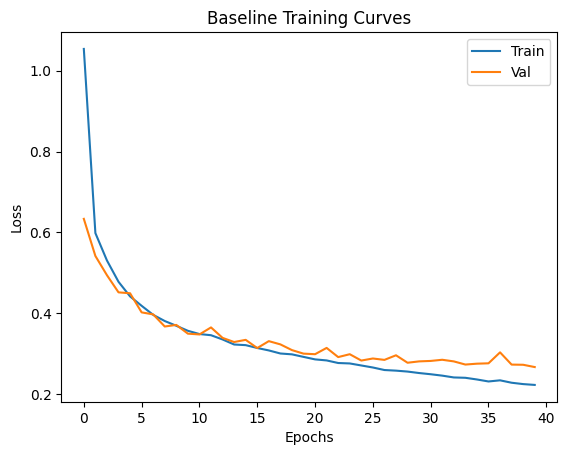

In [75]:
plt.title('Baseline Training Curves')
plt.plot([x.cpu() for x in baseline[0][0]])
plt.plot([x.cpu() for x in baseline[1][0]])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()

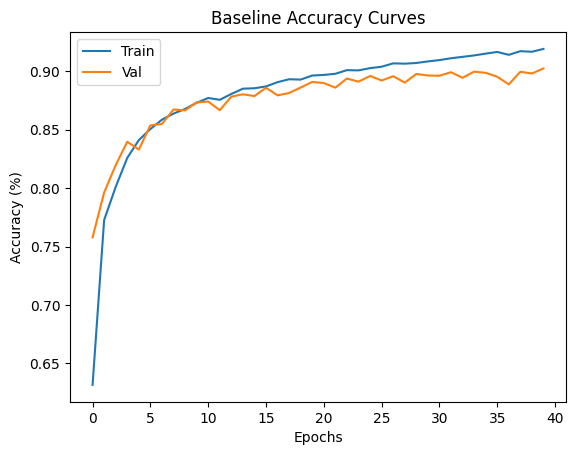

In [77]:
plt.title('Baseline Accuracy Curves')
plt.plot([x for x in baseline[0][2]])
plt.plot([x for x in baseline[1][2]])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Val'])
plt.show()

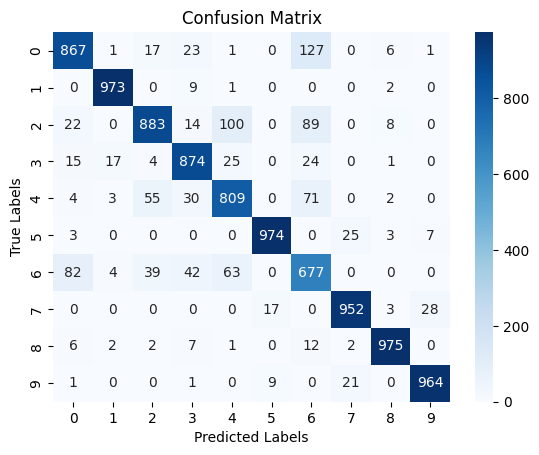

In [91]:
import seaborn as sns
sns.heatmap(baseline[2][1], annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [90]:
print("Train Accuracy:", baseline[0][2][-1])
print("Val Accuracy:", baseline[1][2][-1])
print("Test Accuracy:", baseline[2][2])

Train Accuracy: 0.91914
Val Accuracy: 0.9024
Test Accuracy: 0.8948


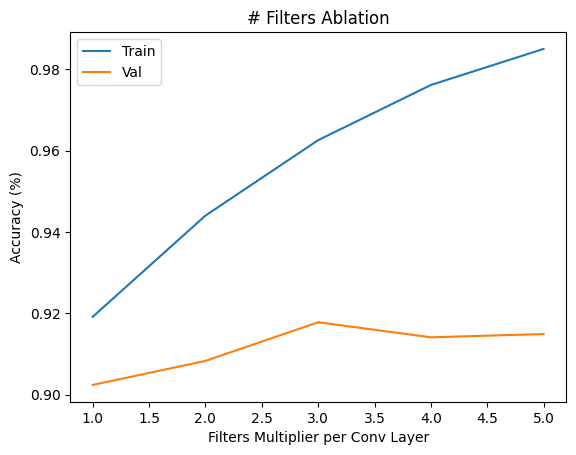

In [98]:
plt.title('# Filters Ablation')
plt.plot(range(1, 6), [baseline[0][2][-1]] + [x[0][2][-1] for x in conv_depth_ablation])
plt.plot(range(1, 6), [baseline[1][2][-1]] + [x[1][2][-1] for x in conv_depth_ablation])
plt.xlabel('Filters Multiplier per Conv Layer')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Val'])
plt.show()

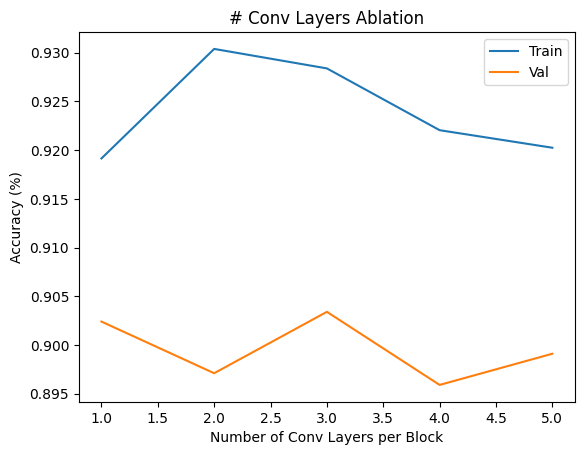

In [101]:
plt.title('# Conv Layers Ablation')
plt.plot(range(1, 6), [baseline[0][2][-1]] + [x[0][2][-1] for x in conv_num_ablation])
plt.plot(range(1, 6), [baseline[1][2][-1]] + [x[1][2][-1] for x in conv_num_ablation])
plt.xlabel('Number of Conv Layers per Block')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Val'])
plt.show()

In [106]:
print("Best Model Test Acc:", conv_depth_ablation[1][2][2])
print("Baseline Model Test Acc:", baseline[2][2])

Best Model Test Acc: 0.911
Baseline Model Test Acc: 0.8948
